In [ ]:
import pandas as pd
from datasets import Dataset
from datasets import load_dataset, load_from_disk, concatenate_datasets
from pathlib import Path
from tqdm import tqdm
import polars as pl
import numpy as np
from joblib import Parallel, delayed
import torch
from torch.utils.data.sampler import BatchSampler, RandomSampler

In [ ]:
#function that reduces the size of pandas dataframe
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
# PATH_DATAST = Path("../data")
# train_meta = pl.scan_parquet(PATH_DATAST / "train_meta.parquet")
# geometry = pd.read_csv(PATH_DATAST / "sensor_geometry.csv")
# geometry["sensor_id"] = geometry["sensor_id"].astype("int16")
# geometry = pl.from_pandas(geometry).lazy()


# def batch_to_hf(batch_id, store_dist=Path("../data/hf_cashe")):

#     fn = PATH_DATAST / "train" / f"batch_{batch_id}.parquet"
#     train = pl.scan_parquet(fn)
#     train = (
#         train.join(geometry, on="sensor_id")
#         .groupby("event_id")
#         .agg([pl.all()])
#         .join(train_meta, on="event_id")
#         .collect()
#     )
#     train = train.to_pandas()[
#         [
#             "event_id",
#             "sensor_id",
#             "time",
#             "charge",
#             "auxiliary",
#             "x",
#             "y",
#             "z",
#             "azimuth",
#             "zenith",
#         ]
#     ]
#     # train = reduce_mem_usage(train)
#     dataset = Dataset.from_pandas(train)
#     dataset.save_to_disk(store_dist / fn.name)


In [ ]:
#get all the batches sorted 
# batches = sorted([int(x.stem.split("_")[1]) for x in (PATH_DATAST / "train").glob("batch_*.parquet")])

In [ ]:
# for i in tqdm(batches):
#     batch_to_hf(i)

from pdb import set_trace

In [ ]:
import torch

In [ ]:
#raed all hugingface datasets and concatenate them into one

#save the dataset to disk with batch_id as name 
#dataset.save_to_disk(PATH_DATAST / "hf_cashe" / "dataset_0-20")


In [ ]:
from copy import deepcopy


class HuggingFaceDataset(torch.utils.data.Dataset):
    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)
        if self.max_events:
            event = event[: self.max_events]
        event["time"] /= event["time"].max()
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])

        event = event.values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "event": torch.tensor(event),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


def collate_fn(batch):
    event = [x["event"] for x in batch]
    mask = [x["mask"] for x in batch]
    label = [x["label"] for x in batch]

    event = torch.nn.utils.rnn.pad_sequence(event, batch_first=True)
    mask = torch.nn.utils.rnn.pad_sequence(mask, batch_first=True)
    batch = {"event": event, "mask": mask, "label": torch.concat(label)}
    return batch


In [ ]:
dataset_custom = HuggingFaceDataset(hf_datasets)

dl = torch.utils.data.DataLoader(
    dataset_custom,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=16, 
    batch_size = 256, 
    persistent_workers=True,
)


In [ ]:
for x in tqdm(dl):
    pass

In [ ]:
len(hf_datasets)

In [1]:
import numpy as np
import plotly
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import plotly.offline as pyo
pio.templates.default='plotly_white'

import torch
import torch.nn as nn

import transformers 
from transformers import AutoModel
from transformers import AdamW
from transformers import (  
    get_constant_schedule, 
    get_constant_schedule_with_warmup, 
    get_cosine_schedule_with_warmup, 
    get_cosine_with_hard_restarts_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    get_polynomial_decay_schedule_with_warmup
)

epochs = 10

In [2]:
class Net(nn.Module):
    def __init__(self, model_name):
        super(Net, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(768, 1)
    def forward(self, input_ids):
        outputs = self.roberta(input_ids)
        sequence_output = outputs[1]
        return self.classifier(sequence_output)

In [3]:
def get_default_layout(title):
    font_style = 'Courier New'
    layout = {}
    layout['height'] = 400
    layout['width'] = 1200
    layout['template'] = 'plotly_white'
    layout['dragmode'] = 'zoom'
    layout['hovermode'] = 'x'
    layout['hoverlabel'] = {
        'font_size': 14,
        'font_family':font_style
    }
    layout['font'] = {
        'size':14,
        'family':font_style,
        'color':'rgb(128, 128, 128)'
    }
    layout['xaxis'] = {
        'title': 'Epochs',
        'showgrid': True,
        'type': 'linear',
        'categoryarray': None,
        'gridwidth': 1,
        'ticks': 'outside',
        'showline': True, 
        'showticklabels': True,
        'tickangle': 0,
        'tickmode': 'array'
    }
    layout['yaxis'] = {
        'title': 'Learning Rate',
        'exponentformat':'none',
        'showgrid': True,
        'type': 'linear',
        'categoryarray': None,
        'gridwidth': 1,
        'ticks': 'outside',
        'showline': True, 
        'showticklabels': True,
        'tickangle': 0,
        'tickmode': 'array'
    }
    layout['title'] = {
        'text':title,
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'family':font_style,
            'size':14,
            'color':'black'
        }
    }
    layout['showlegend'] = True
    layout['legend'] = {
        'x':0.1,
        'y':1.1,
        'orientation':'h',
        'itemclick': 'toggleothers',
        'font': {
            'family':font_style,
            'size':14,
            'color':'black'
        }
    }
    return go.Layout(layout)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


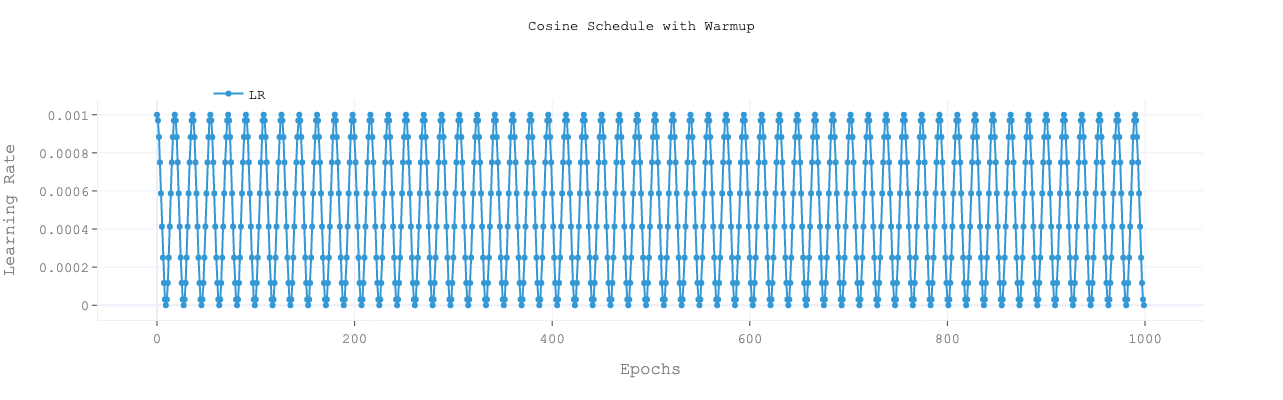

In [16]:
def get_optimizer_params(model, type='s'):
    # differential learning rate and weight decay
    param_optimizer = list(model.named_parameters())
    learning_rate = 5e-5
    no_decay = ['bias', 'gamma', 'beta']
    if type == 's':
        optimizer_parameters = filter(lambda x: x.requires_grad, model.parameters())
    elif type == 'i':
        optimizer_parameters = [
            {'params': [p for n, p in model.roberta.named_parameters() if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in model.roberta.named_parameters() if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0},
            {'params': [p for n, p in model.named_parameters() if "roberta" not in n],
             'lr': 1e-3,
             'weight_decay_rate':0.01}
        ]
    elif type == 'a':
        group1=['layer.0.','layer.1.','layer.2.','layer.3.']
        group2=['layer.4.','layer.5.','layer.6.','layer.7.']    
        group3=['layer.8.','layer.9.','layer.10.','layer.11.']
        group_all=['layer.0.','layer.1.','layer.2.','layer.3.','layer.4.','layer.5.','layer.6.','layer.7.','layer.8.','layer.9.','layer.10.','layer.11.']
        optimizer_parameters = [
            {'params': [p for n, p in model.roberta.named_parameters() if not any(nd in n for nd in no_decay) and not any(nd in n for nd in group_all)],'weight_decay_rate': 0.01},
            {'params': [p for n, p in model.roberta.named_parameters() if not any(nd in n for nd in no_decay) and any(nd in n for nd in group1)],'weight_decay_rate': 0.01, 'lr': learning_rate/2.6},
            {'params': [p for n, p in model.roberta.named_parameters() if not any(nd in n for nd in no_decay) and any(nd in n for nd in group2)],'weight_decay_rate': 0.01, 'lr': learning_rate},
            {'params': [p for n, p in model.roberta.named_parameters() if not any(nd in n for nd in no_decay) and any(nd in n for nd in group3)],'weight_decay_rate': 0.01, 'lr': learning_rate*2.6},
            {'params': [p for n, p in model.roberta.named_parameters() if any(nd in n for nd in no_decay) and not any(nd in n for nd in group_all)],'weight_decay_rate': 0.0},
            {'params': [p for n, p in model.roberta.named_parameters() if any(nd in n for nd in no_decay) and any(nd in n for nd in group1)],'weight_decay_rate': 0.0, 'lr': learning_rate/2.6},
            {'params': [p for n, p in model.roberta.named_parameters() if any(nd in n for nd in no_decay) and any(nd in n for nd in group2)],'weight_decay_rate': 0.0, 'lr': learning_rate},
            {'params': [p for n, p in model.roberta.named_parameters() if any(nd in n for nd in no_decay) and any(nd in n for nd in group3)],'weight_decay_rate': 0.0, 'lr': learning_rate*2.6},
            {'params': [p for n, p in model.named_parameters() if "roberta" not in n], 'lr':1e-3, "momentum" : 0.99},
        ]
    return optimizer_parameters

model = Net('roberta-base')
parameters = get_optimizer_params(model, 's')
kwargs = {
    'betas': (0.9, 0.999),
    'eps': 1e-08
}
optimizer = AdamW(parameters, lr=1e-3, **kwargs)
k =1000
epoch = 10
wamp_up = 0.1
num_warmup_steps = epoch * wamp_up
num_training_steps = epoch
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

learning_rates = []
for i in range(k):
    optimizer.step()
    scheduler.step()
    learning_rates.append(optimizer.param_groups[0]["lr"])
trace = go.Scatter(
    x=np.arange(0, k, 1), 
    y=learning_rates, 
    texttemplate="%{y:.6f}",
    mode='markers+lines',
    name='LR',
    marker=dict(color='#3498d5'),
)
layout=get_default_layout('Cosine Schedule with Warmup')
go.Figure(data=[trace], layout=layout)

In [14]:
len(learning_rates)

100